## Data 3500: Data Dive 3

**Main Questions:** 

Is there a correlation between the number of Oscar wins and viewer ratings for movies?

Are certain genres more likely to win Oscars or receive nominations?

What are the highest rated genres on each platform?

Are there any trends between year of release and highly rated movies?

Does the movie’s runtime affect ratings?

Is there a correlation between the budget allocated for a movie and its box office revenue?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#widen screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Data Exploration

In [2]:
#import the data
films = pd.read_csv('film_data.csv')
oscars = pd.read_csv('oscars.csv')

In [3]:
#merge datasets
data = pd.merge(films, oscars, left_on='Title', right_on='film', how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11213 entries, 0 to 11212
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1613 non-null   float64
 1   Title                    1613 non-null   object 
 2   Year                     1613 non-null   float64
 3   ReleaseDate              1599 non-null   object 
 4   Director                 1606 non-null   object 
 5   Writer                   1294 non-null   object 
 6   Cast                     1263 non-null   object 
 7   Runtime                  1613 non-null   float64
 8   Genre                    1296 non-null   object 
 9   Country                  1295 non-null   object 
 10  Language                 1296 non-null   object 
 11  Budget                   1164 non-null   float64
 12  BoxOffice                1350 non-null   float64
 13  IMDbScore                1526 non-null   float64
 14  IMDbVotes             

## Data Preprocessing

In [4]:
#drop variables that don't help answer questions
columns_to_drop = ['Unnamed: 0', 'Director', 'Writer', 'Cast', 'IMDbVotes', 'IMDbReviews', 'IMDbURL', 'LetterboxdVotes', 'LetterboxdWatches', 'LetterboxdReviews', 'LetterboxdURL', 'MetacriticCriticReviews', 
                   'MetacriticUserVotes', 'MetacriticUserReviews', 'MetacriticURL', 'year_film', 'year_ceremony', 'ceremony', 'name', 'film']
data = data.drop(columns=columns_to_drop)

#get rid of anything after comma in Language and Country
data['Language'] = data['Language'].str.split(',').str[0]
data['Country'] = data['Country'].str.split(',').str[0]

In [5]:
#fill missing object variables with NA
object_columns = data.select_dtypes(include=['object']).columns
data[object_columns] = data[object_columns].fillna('NA')

#fill missing int and floats with mean
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(films[numeric_columns].mean())

#change winner to numerical value
dummy_variables = pd.get_dummies(data['winner'], prefix='winner')
data = pd.concat([data, dummy_variables], axis=1)

#separate top 3 genres and remove rest
genres = data['Genre'].str.split(', ', expand=True)
genres = genres.apply(lambda col: col.str.strip() if col.name is not None else col)
data[['Genre 1', 'Genre 2', 'Genre 3']] = genres.iloc[:, :3].fillna('NA')
data = data.drop(columns=['Genre'])

#create net revenue column
data['NetRevenue'] = data['BoxOffice'] - data['Budget']

In [6]:
data.head()

,Title,Year,ReleaseDate,Runtime,Country,Language,Budget,BoxOffice,IMDbScore,LetterboxdScore,...,MetacriticUserScore,category,winner,winner_False,winner_True,winner_NA,Genre 1,Genre 2,Genre 3,NetRevenue
0,Harakiri,1962.0,15-Sep-62,135.0,JP,Japanese,1.978025e+07,15222.0,8.6,4.67,...,7.600000,NA,NA,0,0,1,Action,Drama,History,-1.976503e+07
1,Come and See,1985.0,9-Jul-85,142.0,USSR,Russian,1.978025e+07,20929648.0,8.4,4.65,...,8.113768,NA,NA,0,0,1,War,NA,NA,1.149400e+06
2,12 Angry Men,1957.0,21-Jun-57,97.0,USA,English,3.500000e+05,955.0,9.0,4.61,...,8.800000,DIRECTING,False,1,0,0,Drama,Crime,NA,-3.490450e+05
3,12 Angry Men,1957.0,21-Jun-57,97.0,USA,English,3.500000e+05,955.0,9.0,4.61,...,8.800000,BEST MOTION PICTURE,False,1,0,0,Drama,Crime,NA,-3.490450e+05
4,12 Angry Men,1957.0,21-Jun-57,97.0,USA,English,3.500000e+05,955.0,9.0,4.61,...,8.800000,WRITING (Screenplay--based on material from an...,False,1,0,0,Drama,Crime,NA,-3.490450e+05


## Data Analysis

## Is there a correlation between the number of Oscar wins and viewer ratings for movies?

In [7]:
#calc mean IMDb scores for Oscar winners and non-winners
mean_scores_imdb = data.groupby('winner_True')['IMDbScore'].mean()
print(f'Mean IMDb Score for Oscar Winners (1-10): {mean_scores_imdb[1]}')
print(f'Mean IMDb Score for Non-Winners(1-10): {mean_scores_imdb[0]}')

Mean IMDb Score for Oscar Winners (1-10): 8.119645949711584
Mean IMDb Score for Non-Winners(1-10): 8.101829150273122


In [8]:
#calc mean Letterboxd scores for Oscar winners and non-winners
mean_scores_letter = data.groupby('winner_True')['LetterboxdScore'].mean()
print(f'Mean IMDb Score for Oscar Winners (1-5): {mean_scores_letter[1]}')
print(f'Mean IMDb Score for Non-Winners (1-5): {mean_scores_letter[0]}')

Mean IMDb Score for Oscar Winners (1-5): 4.202762901991802
Mean IMDb Score for Non-Winners (1-5): 4.199005653189846


In [9]:
#calc mean Metacritic Critic scores for Oscar winners and non-winners
mean_scores_critic = data.groupby('winner_True')['MetacriticCriticScore'].mean()
print(f'Mean IMDb Score for Oscar Winners (1-10): {mean_scores_critic[1]}')
print(f'Mean IMDb Score for Non-Winners (1-10): {mean_scores_critic[0]}')

Mean IMDb Score for Oscar Winners (1-10): 8.438522565158845
Mean IMDb Score for Non-Winners (1-10): 8.417088384886355


In [10]:
#calc mean Metacritic User scores for Oscar winners and non-winners
mean_scores_user = data.groupby('winner_True')['MetacriticUserScore'].mean()
print(f'Mean IMDb Score for Oscar Winners (1-10): {mean_scores_user[1]}')
print(f'Mean IMDb Score for Non-Winners (1-10): {mean_scores_user[0]}')

Mean IMDb Score for Oscar Winners (1-10): 8.147920604914626
Mean IMDb Score for Non-Winners (1-10): 8.119853090550363


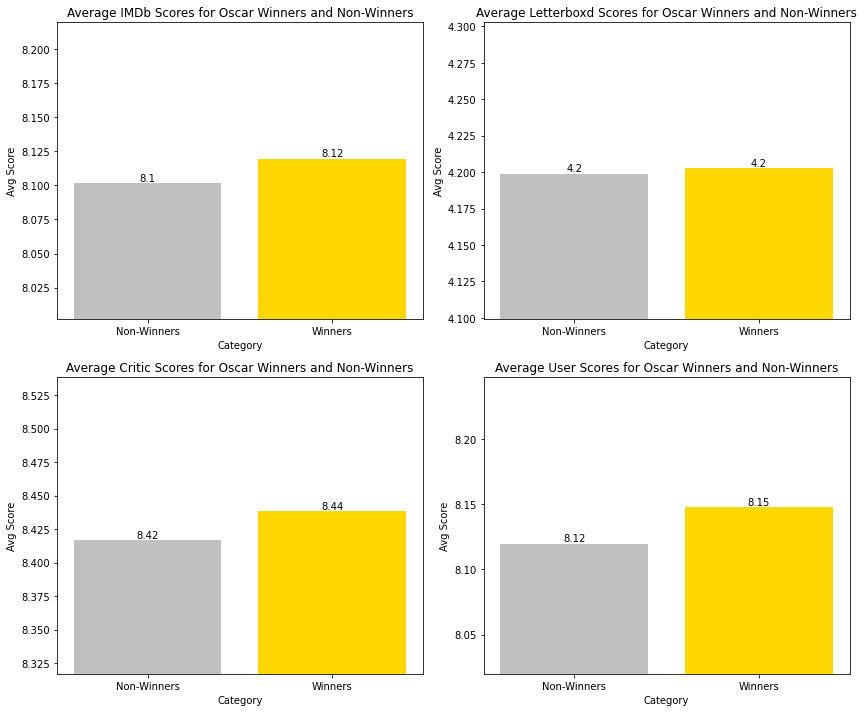

In [21]:
#visualize the mean scores for each platform
categories = ['Non-Winners', 'Winners']

#function to create a bar plot
def plot_bar(ax, mean_scores, title):
    bars = ax.bar(categories, mean_scores, color=['silver', 'gold'])
    ax.set_ylim(np.min(mean_scores) - 0.1, np.max(mean_scores) + 0.1)
    ax.set_title(title)
    ax.set_xlabel('Category')
    ax.set_ylabel('Avg Score')

    #add labels on top
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

#create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

#plot graphs (this includes movies not nominated)
plot_bar(axs[0, 0], mean_scores_imdb, 'Average IMDb Scores for Oscar Winners and Non-Winners')
plot_bar(axs[0, 1], mean_scores_letter, 'Average Letterboxd Scores for Oscar Winners and Non-Winners')
plot_bar(axs[1, 0], mean_scores_critic, 'Average Critic Scores for Oscar Winners and Non-Winners')
plot_bar(axs[1, 1], mean_scores_user, 'Average User Scores for Oscar Winners and Non-Winners')

plt.tight_layout()
plt.show()

## Are certain genres more likely to win Oscars or receive nominations?

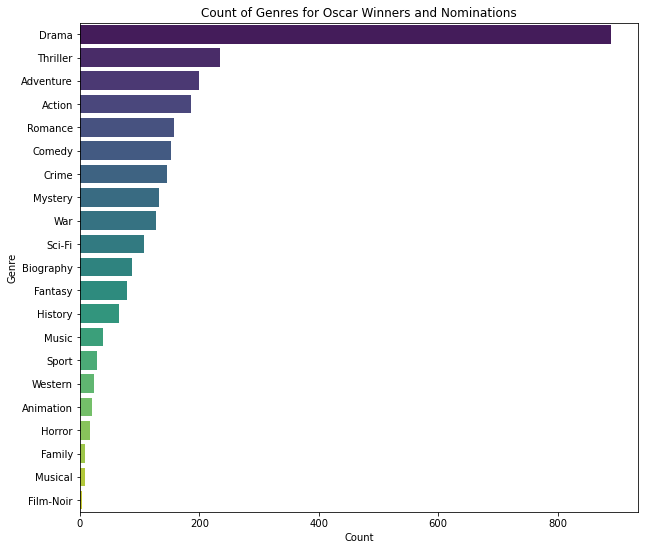

In [12]:
#only include noms and winners
filtered_data = data[(data['winner_False'] == 1) | (data['winner_True'] == 1)]

#combine genres into new dataframe for noms and winners
genres_df = filtered_data[['Genre 1', 'Genre 2', 'Genre 3']]
stacked_genres = genres_df.stack().reset_index(level=1, drop=True).reset_index(name='Genre')

#count instances of each genre
genre_counts = stacked_genres['Genre'].value_counts().reset_index()

#drop 'NA'
genre_counts = genre_counts[genre_counts['index'] != 'NA']

#plot
plt.figure(figsize=(10, 9))
sns.barplot(x='Genre', y='index', data=genre_counts, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Count of Genres for Oscar Winners and Nominations')
plt.show()

## What are the highest rated genres on each platform?

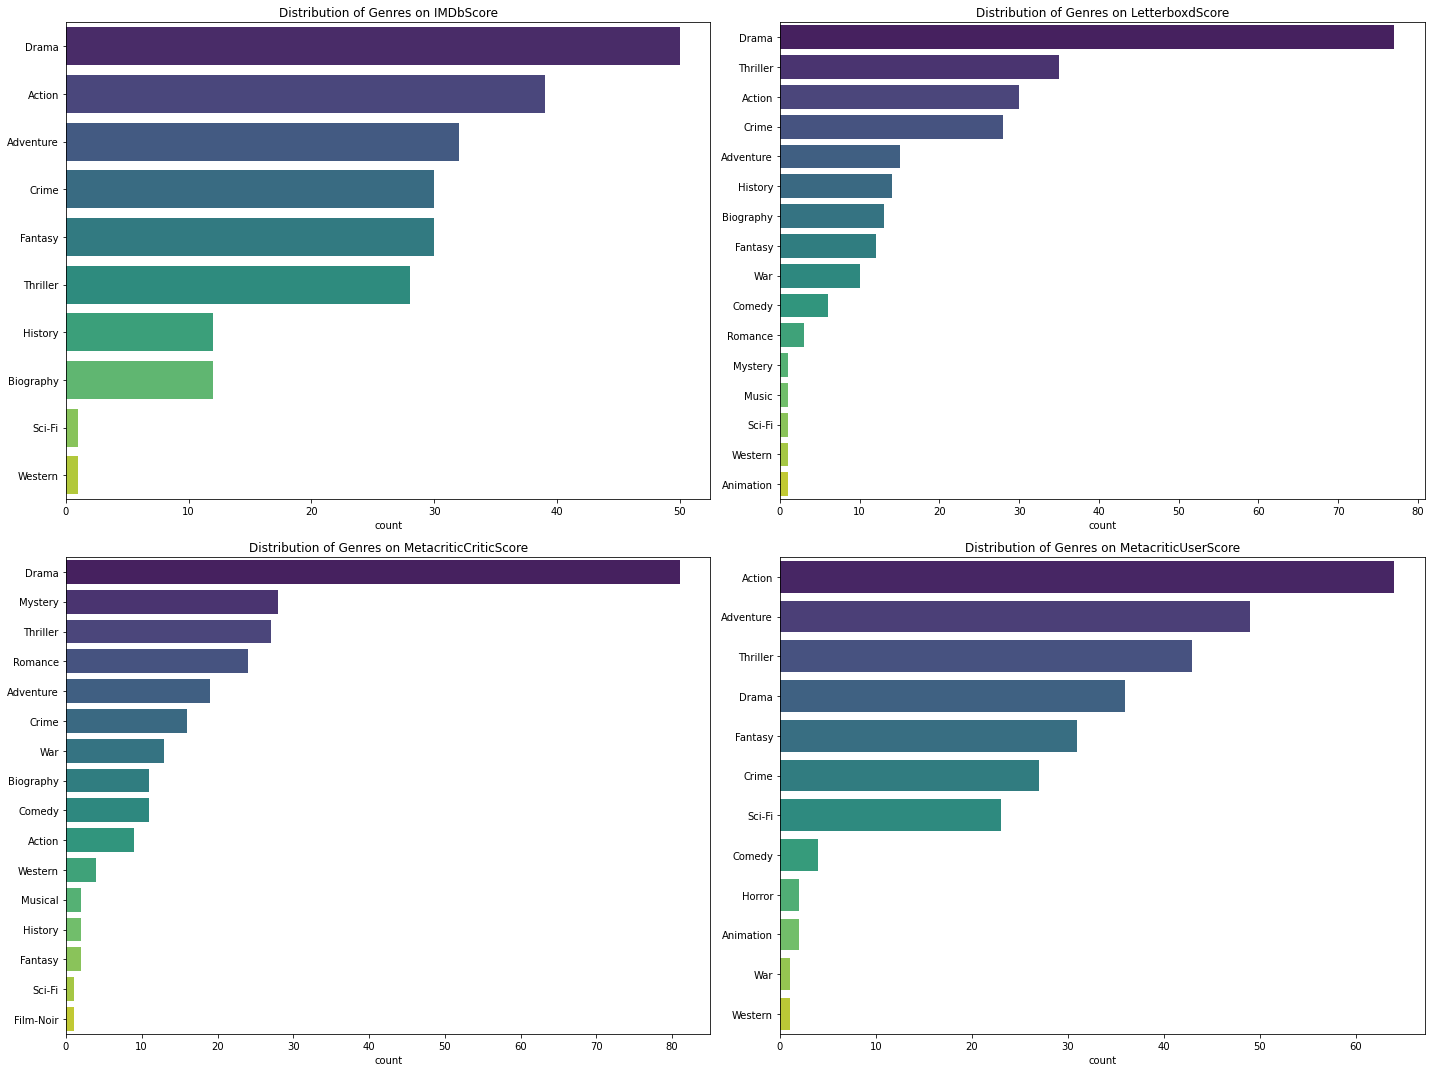

In [13]:
#making countplot of the distribution of genres based on top 100 reviews on each platform

#formatting plots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

#function to get top genres and plot countplot
def plot_top_genres(platform_column, ax):
    top_100_scores = data.nlargest(100, platform_column)
    top_genres = top_100_scores[['Genre 1', 'Genre 2', 'Genre 3']].stack().reset_index(level=1, drop=True).str.strip()
    
    #exclude 'NA'
    top_genres = top_genres[top_genres != 'NA']
    
    sns.countplot(y=top_genres, order=top_genres.value_counts().index, palette='viridis', ax=ax)
    ax.set_title(f'Distribution of Genres on {platform_column}')

#plotting each platform distribution
plot_top_genres('IMDbScore', axes[0, 0])
plot_top_genres('LetterboxdScore', axes[0, 1])
plot_top_genres('MetacriticCriticScore', axes[1, 0])
plot_top_genres('MetacriticUserScore', axes[1, 1])

plt.tight_layout()
plt.show()

## Are there any trends between year of release and highly rated movies?

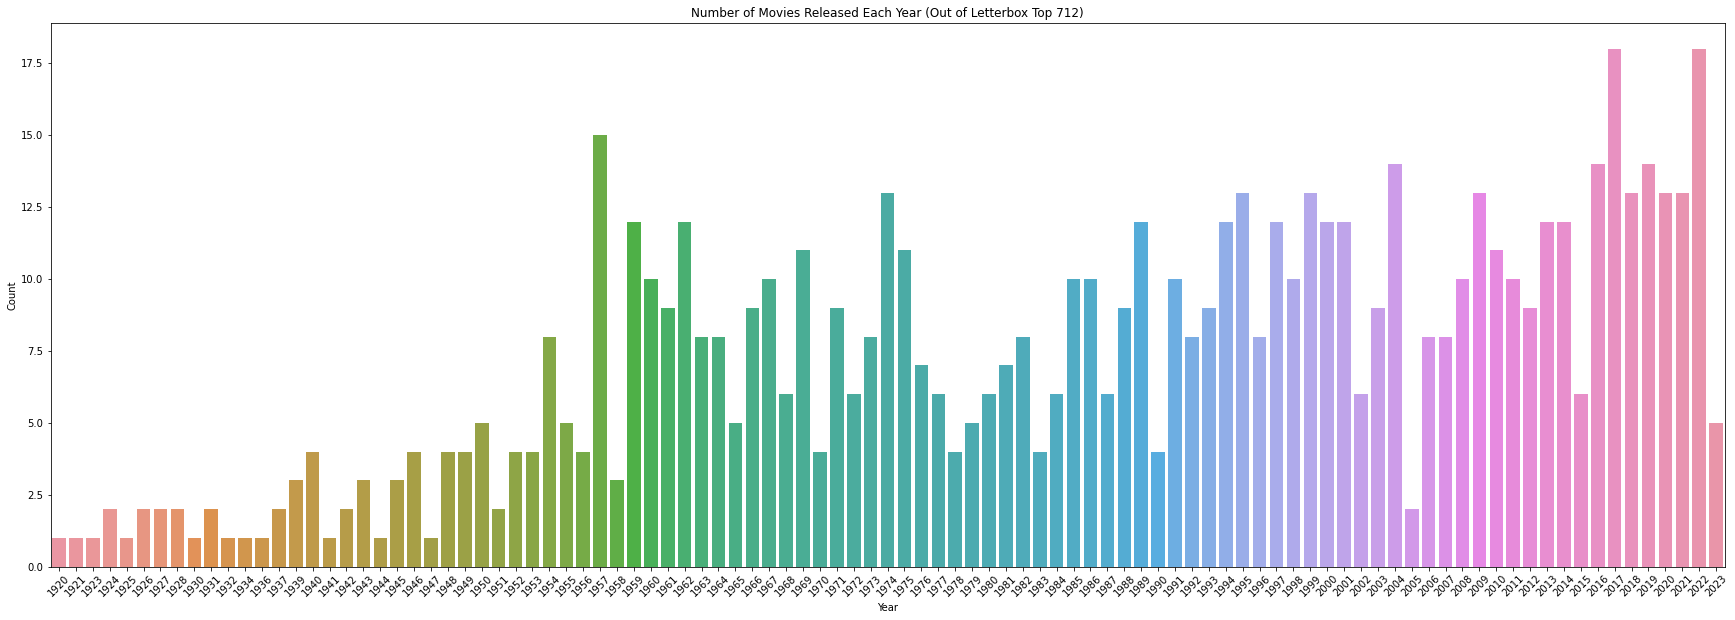

In [14]:
#graph for numbers of movies in each year
plt.figure(figsize=(30, 10))
sns.countplot(x='Year', data=films)
plt.title('Number of Movies Released Each Year (Out of Letterbox Top 712)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Does the movie’s runtime affect ratings?

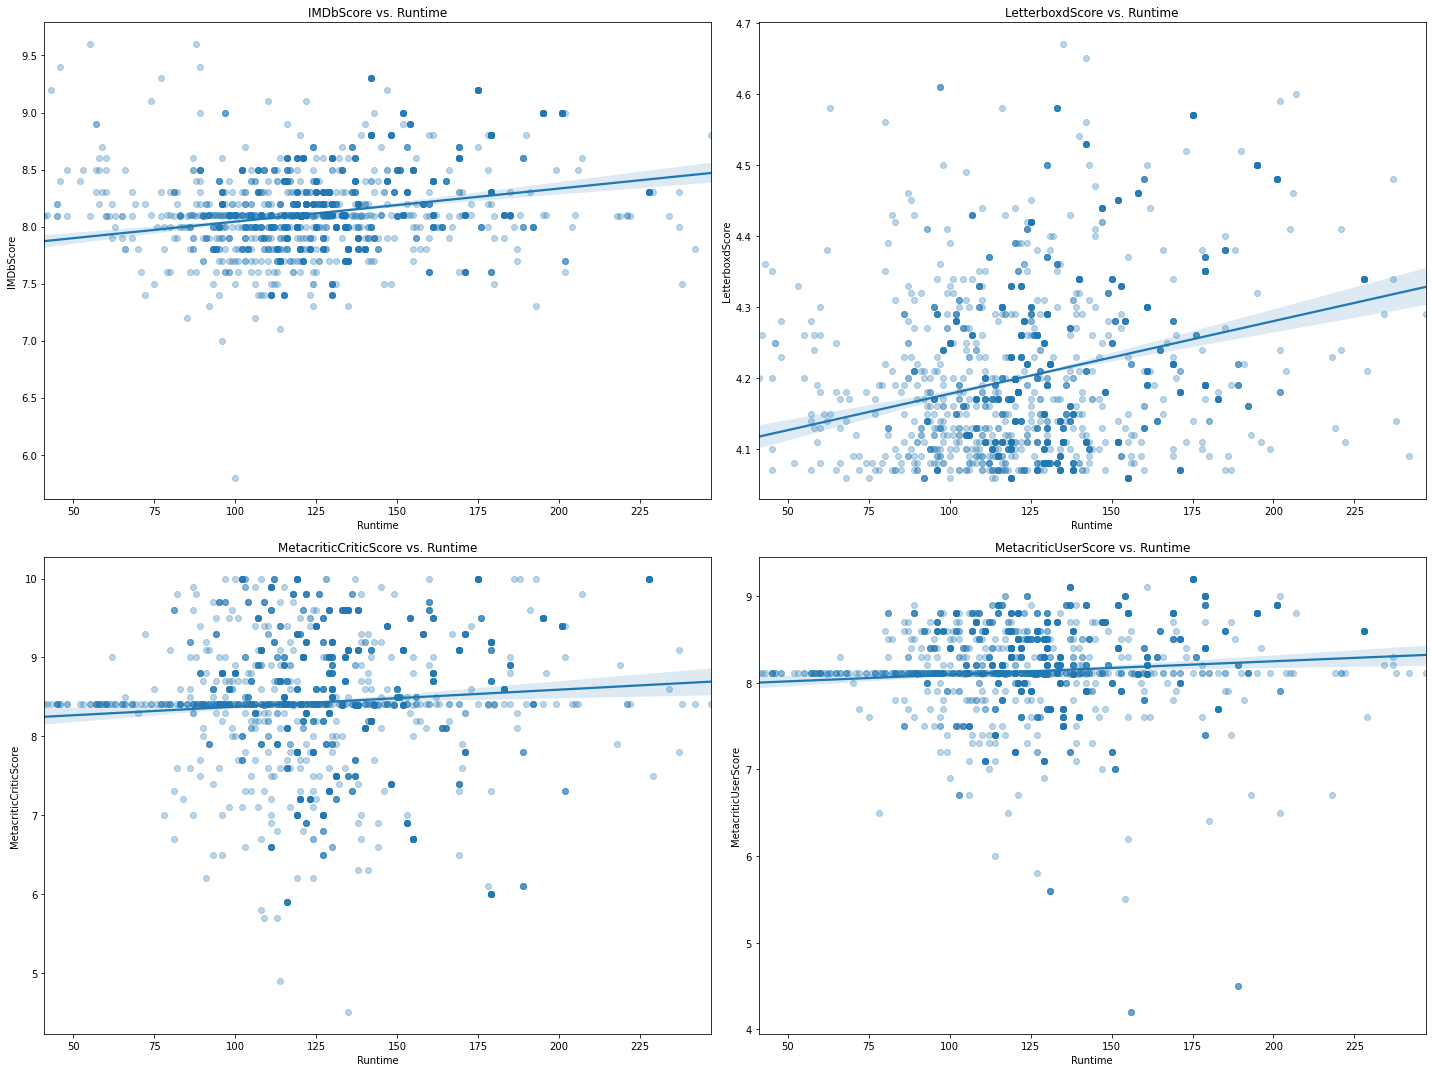

In [15]:
#platform scores
score_columns = ['IMDbScore', 'LetterboxdScore', 'MetacriticCriticScore', 'MetacriticUserScore']

#scatter plots with regression lines for each type of score
plt.figure(figsize=(20, 15))

for i, score_column in enumerate(score_columns, 1):
    plt.subplot(2, 2, i)
    sns.regplot(x='Runtime', y=score_column, data=data, scatter_kws={'alpha': 0.3})
    plt.title(f'{score_column} vs. Runtime')

plt.tight_layout()
plt.show()

## Is there a correlation between the budget allocated for a movie and its box office revenue?

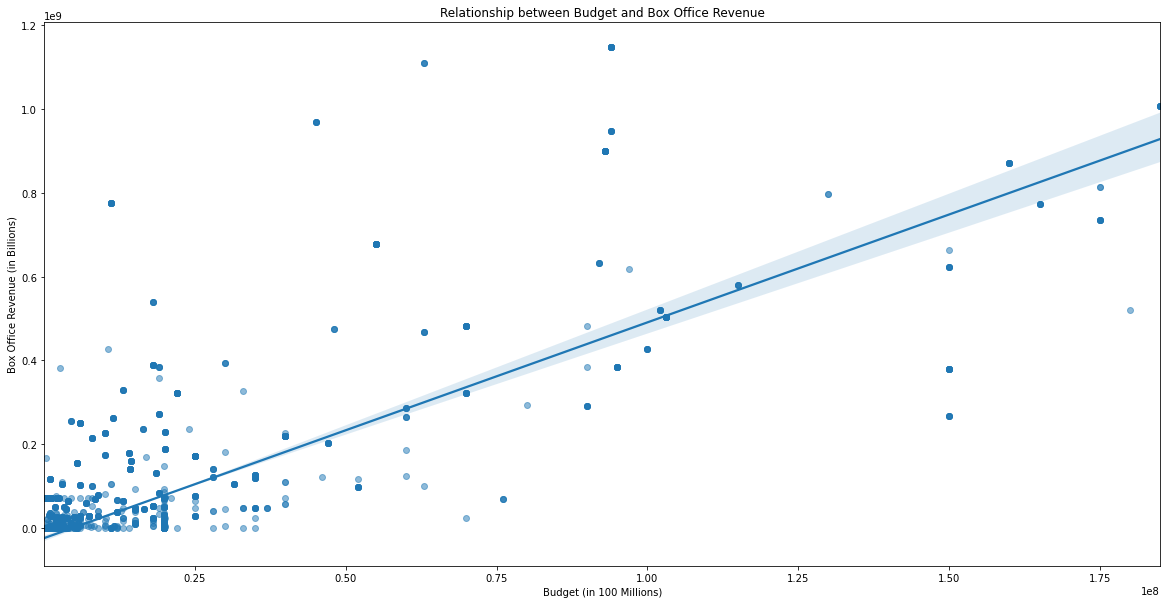

In [16]:
#scatterplot for Budget and BoxOffice
plt.figure(figsize=(20, 10))
sns.regplot(x='Budget', y='BoxOffice', data=data, scatter_kws={'alpha': 0.5})
plt.title('Relationship between Budget and Box Office Revenue')
plt.xlabel('Budget (in 100 Millions)')
plt.ylabel('Box Office Revenue (in Billions)')
plt.show()

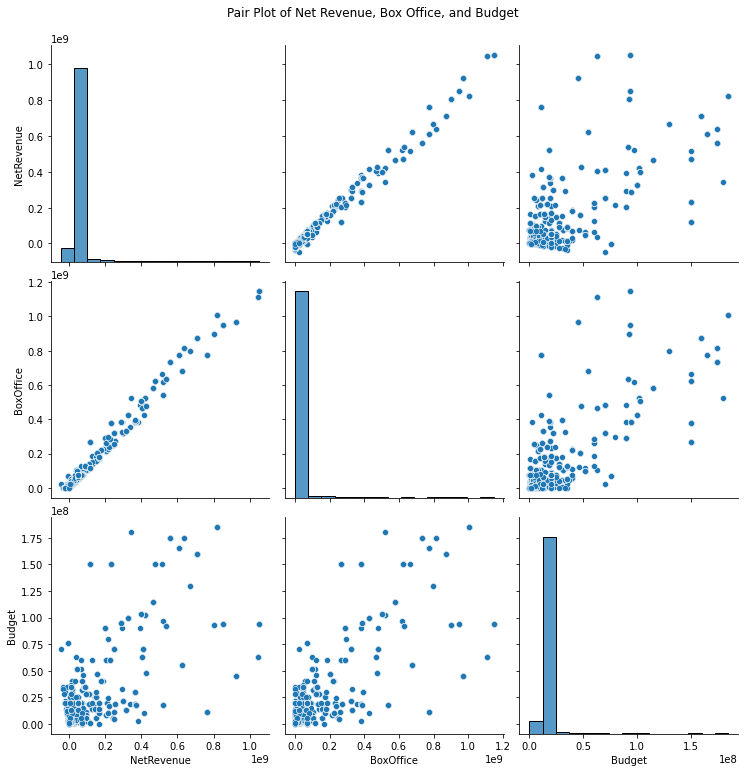

In [17]:
#create pair plot
selected_columns = ['NetRevenue', 'BoxOffice', 'Budget']
sns.pairplot(data[selected_columns], height=3.5)  # Adjust the height parameter
plt.suptitle('Pair Plot of Net Revenue, Box Office, and Budget', y=1.02)
plt.show()